<a href="https://colab.research.google.com/github/mohamedchnafy-ds/python_project/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd '/content/drive/MyDrive/python project/input_data'

/content/drive/MyDrive/python project/input_data


# Import librairies

In [15]:
import pandas as pd
import numpy as np
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import os
import psycopg2
from urllib.parse import quote_plus
import plotly.express as px
import plotly.io as pio
from functools import reduce
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import geopandas as gpd
import requests
import json

In [16]:
path = '/content/drive/MyDrive/python project/input_data'

# Loading data

In [17]:
file_names = ['ITRF2020_DORIS_cart.txt', 'ITRF2020_GNSS_cart.txt', 'ITRF2020_SLR_cart.txt', 'ITRF2020_VLBI_cart.txt']

In [18]:
def read_merged_data(multiple_file):
    data_frames = []
    for file_name in file_names:
        file_path = os.path.join(path, file_name)  # Use os.path.join for platform compatibility
        df = pd.read_fwf(file_path)
        data_frames.append(df)

    data_merged = pd.concat(data_frames, ignore_index=True)
    return data_merged

# data_merged = pd.concat(data_frames, ignore_index=True)
data_merged  = read_merged_data(multiple_file =file_names )
data_merged

,id,name,type,code,x,y,z,dx,dy,dz
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,5.561665e+05,4.389372e+06,0.002,0.0025,0.002
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,5.561669e+05,4.389371e+06,0.0019,0.0024,0.0017
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,1.196707e+05,4.372788e+06,0.0054,0.0062,0.0051
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,1.199851e+05,4.372105e+06,0.0034,0.0042,0.0032
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,1.199851e+05,4.372105e+06,0.0026,0.0039,0.0025
...,...,...,...,...,...,...,...,...,...,...
1837,50243S001,Warkworth,VLBI,7377,-5.115324e+06,4.778433e+05,-3.767193e+06,0.0017,0.0012,0.0016
1838,50505S003,KWAJALEIN ATOLL,VLBI,4968,-6.143536e+06,1.363999e+06,1.034708e+06,0.8689,0.2507,0.3272
1839,59968S001,Katherine - Nor,VLBI,7375,-4.147355e+06,4.581542e+06,-1.573303e+06,0.0014,0.0014,0.0012
1840,66006S004,Syowa,VLBI,7342,1.766194e+06,1.460411e+06,-5.932273e+06,0.0034,0.0031,0.0071


#  Creation of geodataframe

In [19]:
gdf_before = gpd.GeoDataFrame(
    data_merged, geometry=gpd.points_from_xy(data_merged.x, data_merged.y,data_merged.z), crs="EPSG:4978")
gdf = gdf_before.to_crs(4326)
gdf['site_id'] = gdf['id'].str.extract('(\d+)')
gdf['instrument_id'] = gdf['id'].str.extract('\d+([A-Za-z].+)')

In [20]:
summary = gdf.groupby('site_id').agg(
    instrument_nb=('instrument_id', 'count'),
    types=('type', 'nunique')
).reset_index()

# Renommer les colonnes si nécessaire
summary.columns = ['site_id', 'instrument_nb', 'types']
summary

,site_id,instrument_nb,types
0,10001,2,1
1,10002,7,4
2,10003,6,2
3,10004,3,2
4,10012,2,1
...,...,...,...
1241,97309,1,1
1242,97401,4,2
1243,97413,1,1
1244,97415,1,1


In [21]:
summary_gdf = summary[(summary.instrument_nb>= 3) & (summary.types >= 2 ) ]
summary_gdf

,site_id,instrument_nb,types
1,10002,7,4
2,10003,6,2
3,10004,3,2
14,10077,3,3
26,10202,5,2
...,...,...,...
1217,92301,4,2
1222,92701,6,2
1233,92902,3,2
1239,97301,5,2


In [22]:
gdf_site = gdf[gdf['site_id'].isin(summary_gdf.site_id.tolist())]
gdf_site

,id,name,type,code,x,y,z,dx,dy,dz,geometry,site_id,instrument_id
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,5.561665e+05,4.389372e+06,0.002,0.0025,0.002,POINT Z (6.92123 43.75483 1323.70087),10002,S018
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,5.561669e+05,4.389371e+06,0.0019,0.0024,0.0017,POINT Z (6.92123 43.75483 1323.8158),10002,S019
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,1.196707e+05,4.372788e+06,0.0054,0.0062,0.0051,POINT Z (1.48121 43.55814 207.69101),10003,S001
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,1.199851e+05,4.372105e+06,0.0034,0.0042,0.0032,POINT Z (1.48489 43.54962 210.79597),10003,S003
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,1.199851e+05,4.372105e+06,0.0026,0.0039,0.0025,POINT Z (1.48489 43.54962 211.08413),10003,S005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,50107S012,Yarragadee,VLBI,7376,-2.388896e+06,5.043350e+06,-3.078591e+06,0.0012,0.0014,0.0013,POINT Z (115.34563 -29.04714 248.2326),50107,S012
1835,50116S002,Hobart,VLBI,7242,-3.950237e+06,2.522348e+06,-4.311562e+06,0.0014,0.0012,0.0014,POINT Z (147.44052 -42.80358 65.08972),50116,S002
1836,50116S007,Hobart,VLBI,7374,-3.949991e+06,2.522421e+06,-4.311708e+06,0.0014,0.0012,0.0015,POINT Z (147.43814 -42.80557 40.95217),50116,S007
1840,66006S004,Syowa,VLBI,7342,1.766194e+06,1.460411e+06,-5.932273e+06,0.0034,0.0031,0.0071,POINT Z (39.58628 -69.00632 51.02068),66006,S004


In [23]:
sites_dissolved_all = gdf.dissolve(
    by='site_id',
    aggfunc={
        'instrument_id': 'count',
        'type': 'nunique'
    }
).reset_index()

In [24]:
sites_dissolved_all

,site_id,geometry,instrument_id,type
0,10001,"MULTIPOINT Z (2.33494 48.83592 122.58673, 2.33...",2,1
1,10002,"MULTIPOINT Z (6.92058 43.75474 1319.30335, 6.9...",7,4
2,10003,"MULTIPOINT Z (1.48076 43.56077 207.09635, 1.48...",6,2
3,10004,"MULTIPOINT Z (-4.50383 48.40787 104.42082, -4....",3,2
4,10012,"MULTIPOINT Z (7.22726 43.70327 256.49109, 7.29...",2,1
...,...,...,...,...
1241,97309,POINT Z (-52.58675 5.28468 -28.00331),1,1
1242,97401,"MULTIPOINT Z (55.57172 -21.20822 1558.37142, 5...",4,2
1243,97413,POINT Z (55.28449 -20.9644 23.10689),1,1
1244,97415,POINT Z (55.49523 -20.89676 49.27391),1,1


In [26]:
sites_dissolved = sites_dissolved_all[(sites_dissolved_all['instrument_id'] >=3) & (sites_dissolved_all['type'] >=2)]
sites_dissolved


,site_id,geometry,instrument_id,type
1,10002,"MULTIPOINT Z (6.92058 43.75474 1319.30335, 6.9...",7,4
2,10003,"MULTIPOINT Z (1.48076 43.56077 207.09635, 1.48...",6,2
3,10004,"MULTIPOINT Z (-4.50383 48.40787 104.42082, -4....",3,2
14,10077,"MULTIPOINT Z (8.76246 41.92747 98.24128, 8.762...",3,3
26,10202,"MULTIPOINT Z (-21.99518 64.15098 95.75501, -21...",5,2
...,...,...,...,...
1217,92301,"MULTIPOINT Z (-134.96492 -23.13026 82.2131, -1...",4,2
1222,92701,"MULTIPOINT Z (166.41006 -22.26983 83.06194, 16...",6,2
1233,92902,"MULTIPOINT Z (-178.121 -14.30778 85.73272, -17...",3,2
1239,97301,"MULTIPOINT Z (-52.80597 5.25219 -25.77014, -52...",5,2


In [27]:
def multipoint_to_polygon(geometry):

    return geometry.convex_hull

sites_polygons = sites_dissolved.copy()
sites_polygons.geometry = sites_polygons.geometry.apply(multipoint_to_polygon)

In [28]:
sites_polygons

,site_id,geometry,instrument_id,type
1,10002,"POLYGON Z ((6.92077 43.75449 1319.85842, 6.920...",7,4
2,10003,"POLYGON Z ((1.48489 43.54962 210.79597, 1.4812...",6,2
3,10004,"POLYGON Z ((-4.49659 48.3805 65.82489, -4.5038...",3,2
14,10077,"POLYGON Z ((8.7627 41.92739 96.80211, 8.76246 ...",3,3
26,10202,"POLYGON Z ((-21.95549 64.13879 93.04831, -21.9...",5,2
...,...,...,...,...
1217,92301,"POLYGON Z ((-134.96483 -23.13035 80.64485, -13...",4,2
1222,92701,"POLYGON Z ((166.4102 -22.26985 83.04824, 166.4...",6,2
1233,92902,"POLYGON Z ((-178.12095 -14.3078 84.87284, -178...",3,2
1239,97301,"POLYGON Z ((-52.63975 5.09847 107.24563, -52.8...",5,2


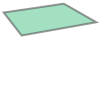

In [29]:
# sites_polygons.geometry[1]

In [30]:
# def request_images(wkt_geometry):
#     items = [] # Empty list to store return elements
#     # Request
#     r = requests.get(
#         "https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json",
#         params={
#             "geometry": wkt_geometry,
#             "startDate": "2022-01-01T00:00:00.000Z",
#             "completionDate": "2022-09-30T23:59:59.999Z",
#             "cloudCover": "[0,10]",
#             "maxRecords": 20,
#             "page": 1,
#         }
#     )
#     # If status_code is not 200, we have an issue
#     if r.status_code == 200:
#         data = r.json()
#         if 'features' in data:
#             items += data['features']
#     return items

# #wkt_geometry = 'POLYGON((2.349250 48.8535,2.348703 48.85293,2.350430 48.8524,2.35091 48.8530,2.349250 48.8535))'
# #images = request_images(wkt_geometry)

In [ ]:
# sites_polygons

,site_id,geometry,instrument_id,type
1,10002,"POLYGON Z ((6.92077 43.75449 1319.85842, 6.920...",7,4
2,10003,"POLYGON Z ((1.48489 43.54962 210.79597, 1.4812...",6,2
3,10004,"POLYGON Z ((-4.49659 48.3805 65.82489, -4.5038...",3,2
14,10077,"POLYGON Z ((8.7627 41.92739 96.80211, 8.76246 ...",3,3
26,10202,"POLYGON Z ((-21.95549 64.13879 93.04831, -21.9...",5,2
...,...,...,...,...
1217,92301,"POLYGON Z ((-134.96483 -23.13035 80.64485, -13...",4,2
1222,92701,"POLYGON Z ((166.4102 -22.26985 83.04824, 166.4...",6,2
1233,92902,"POLYGON Z ((-178.12095 -14.3078 84.87284, -178...",3,2
1239,97301,"POLYGON Z ((-52.63975 5.09847 107.24563, -52.8...",5,2


In [31]:

# temp_dir = "temp_files"  # Create a directory for temp files
# os.makedirs(temp_dir, exist_ok=True)

# all_images = []
# for idx, geometry in enumerate(sites_polygons.geometry):
#     site_id = sites_polygons.index[idx]  # Assuming you have site IDs
#     temp_file = os.path.join(temp_dir, f"{site_id}.json")

#     # Check if temp file exists
#     if os.path.exists(temp_file) and os.path.getsize(temp_file) > 0:  # Check file size:
#         with open(temp_file, 'r') as f:
#             images = json.load(f)
#     else:
#         images = request_images(geometry)
#         # Save to temp file
#         with open(temp_file, 'w') as f:
#             json.dump(images, f)

#     all_images.append(images)

In [ ]:
# k = []
# for i in range(len(all_images)):
#   k.append(len(all_images[i]))
# #calcul sum of list k
# sum(k)

1865

In [33]:
# all_gdf = gpd.GeoDataFrame(
#    columns=['id', 'title', 'url']
# )

In [34]:
# # Loop and concat
# for i in range(len(all_images)):
#    features = all_images[i]
#    gdf = gpd.GeoDataFrame(
#        data=[{
#            'id': f['id'],
#            'title': f['properties']['title'],
#            'url': f['properties']['services']['download']['url']
#        } for f in features]
#    )
#    all_gdf = pd.concat([all_gdf, gdf], ignore_index=True)
# all_gdf

,id,title,url
0,3af0b46f-b626-5ad2-af5a-9b75beae12df,S2B_MSIL1C_20220129T103159_N0400_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
1,3fb65452-79f3-59eb-b944-85f664ab1cc1,S2A_MSIL2A_20220121T102331_N9999_R065_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
2,d5962479-5473-52c2-93b7-ad0b3823a658,S2A_MSIL1C_20220124T103331_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
3,63d2aee3-51bf-54c1-b37c-21a6da00f0ee,S2A_MSIL2A_20220124T103331_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
4,7b242d90-95f1-545c-86c0-75d3913239cc,S2B_MSIL2A_20220109T103319_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
...,...,...,...
1860,b559e7b0-1f96-51bc-9e47-98da81cc4440,S2A_MSIL1C_20220725T063521_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
1861,ca5fd93b-04ce-5edc-ae18-4f7441eb386e,S2B_MSIL2A_20220501T063509_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
1862,9595d3a2-3f82-5c0c-be1c-fcf8d9fe579d,S2B_MSIL1C_20220521T063509_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
1863,030f7ba1-a365-5ed9-8f10-a6f6f187ffbf,S2A_MSIL2A_20220725T063521_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...


In [35]:
def get_and_cache_images(sites_polygons, temp_dir="temp_files"):
    """Récupère les images de Copernicus, les met en cache et crée un GeoDataFrame.

    Args:
        sites_polygons: GeoDataFrame avec une colonne 'geometry' contenant les polygones des sites.
        temp_dir: Répertoire pour stocker les fichiers JSON en cache.

    Returns:
        Un GeoDataFrame contenant les informations des images.
    """
    os.makedirs(temp_dir, exist_ok=True)
    all_images = []
    for idx, geometry in enumerate(sites_polygons.geometry):
        site_id = sites_polygons.index[idx]
        temp_file = os.path.join(temp_dir, f"{site_id}.json")

        if os.path.exists(temp_file) and os.path.getsize(temp_file) > 0:
            with open(temp_file, 'r') as f:
                images = json.load(f)
        else:
            items = []
            r = requests.get(
                "https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json",
                params={
                    "geometry": geometry,
                    "startDate": "2022-01-01T00:00:00.000Z",
                    "completionDate": "2022-09-30T23:59:59.999Z",
                    "cloudCover": "[0,10]",
                    "maxRecords": 20,
                    "page": 1,
                }
            )
            if r.status_code == 200:
                data = r.json()
                if 'features' in data:
                    items += data['features']
            images = items
            with open(temp_file, 'w') as f:
                json.dump(images, f)

        all_images.append(images)

    # Create the GeoDataFrame
    all_gdf = gpd.GeoDataFrame(columns=['id', 'title', 'url'])
    for features in all_images:
        gdf = gpd.GeoDataFrame(
            data=[{
                'id': f['id'],
                'title': f['properties']['title'],
                'url': f['properties']['services']['download']['url']
            } for f in features]
        )
        all_gdf = pd.concat([all_gdf, gdf], ignore_index=True)

    return all_gdf  # Return the GeoDataFrame

In [36]:
one_geodataframe = get_and_cache_images(sites_polygons)
one_geodataframe

,id,title,url
0,3af0b46f-b626-5ad2-af5a-9b75beae12df,S2B_MSIL1C_20220129T103159_N0400_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
1,3fb65452-79f3-59eb-b944-85f664ab1cc1,S2A_MSIL2A_20220121T102331_N9999_R065_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
2,d5962479-5473-52c2-93b7-ad0b3823a658,S2A_MSIL1C_20220124T103331_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
3,63d2aee3-51bf-54c1-b37c-21a6da00f0ee,S2A_MSIL2A_20220124T103331_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
4,7b242d90-95f1-545c-86c0-75d3913239cc,S2B_MSIL2A_20220109T103319_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/down...
...,...,...,...
1860,b559e7b0-1f96-51bc-9e47-98da81cc4440,S2A_MSIL1C_20220725T063521_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
1861,ca5fd93b-04ce-5edc-ae18-4f7441eb386e,S2B_MSIL2A_20220501T063509_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
1862,9595d3a2-3f82-5c0c-be1c-fcf8d9fe579d,S2B_MSIL1C_20220521T063509_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
1863,030f7ba1-a365-5ed9-8f10-a6f6f187ffbf,S2A_MSIL2A_20220725T063521_N0400_R134_T40KCB_2...,https://catalogue.dataspace.copernicus.eu/down...
